
# Project 3: Classifying a Reddit post

--- 
# Part 1

---

## Problem Statement


#### Reddit moderators want to figure out how to increase engagement especially when 2 two subreddits are very similar. This is very common in new groups which are more ‘specialized’ versions of the parent group. Examples: marketing and social media marketing; fitness and running



### Contents:
- [Background](#Background)
- [The Data](#The-Data)
- [Get Data from Reddit](#Get-Data-from-Reddit)
- [Data Cleaning and EDA](#Data-Cleaning-and-EDA)
- [Visualizations](#Visualizations)

## Background <a class="anchor" id="Background"></a>

- Reddit: 3M subreddits, only 130k active, hundreds new every week  

A data scientist has been hired by the Reddit Moderators to figure out how to increase karma when two subreddits are similar. 
New groups, particularly when the new one is a specialized version or a subset of the broader community group tend to have less engagement initially. When a new post is being submitted, if we can auto-submit it to the newer subreddit, it increases its visibility and provides a higher chance for the posters to get more upvotes and hence increase their karma (the Reddit equivalent of points).

Examples: marketing and social media marketing; fitness and running, or Running and CouchTo5K (a group for first-time runners to get to run a distance of 5km). 

This service will also provide a solution by cross-posting to both subreddits if we cannot predict reliably, with the aim to fit within the Reddiquette guidelines. 





### The Data <a class="anchor" id="The-Data"></a>

#### Input Data
  
Using data obtained from [Pushshift's](https://github.com/pushshift/api) API, we'll collect posts from the running and c25k subreddits.   
Ideally want about 10000 observations from each. Got 10,000 from running and 4,000 from c25k



#### Output Data files

* [`running.csv`](../data/running.csv): Data from the Reddit running subreddit
* [`c25k.csv`](../data/c25k.csv): Data from the Reddit c25k subreddit



#### Intermediate Data files

To provide a cleaner break between the different facets of modeling and to permit simpler navigation across notebooks, I created a number of intermediate files. These files are used in the model training and evaluation in notebooks 2 and 3. 

**Model evaluation metrics for each of the 4 classifiers**

best_rf_results_df.csv
svc_results_df.csv
knn_results_df.csv
et_results_df.csv

**Pickle files for the stop words**
stop_words_100_body.pkl
stop_words_100_t_s.pkl
stop_words_100_title.pkl
stop_words_1000_body.pkl
stop_words_1000_t_s.pkl
stop_words_1000_title.pkl
stop_words.pkl



### Outside Research

Reddit Reddiquette and karma, stats on number of subreddits  

SVC predicted_proba limitations: https://scikit-learn.org/stable/modules/svm.html#scores-probabilities



In [1]:
# Imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import time
import requests

from sklearn.feature_extraction import text 




## Get Data from Reddit <a class="anchor" id="Get-Data-from-Reddit"></a>

- Use the pushshift API
- The two subreddits: running and C25k (CouchTo5K)
- Get about 10k rows which is a decent balance for model training purposes

In [2]:
# function that returns dataframe of subreddit posts. Can accept multiple subreddits 

def query_pushshift(subreddit, kind = 'submission', day_window = 10, n = 5):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self']
    
    # establish base url and stem

    # Establish URL base
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}" # also known as the "API endpoint" 

    
    # construct full url
    stem = f"{BASE_URL}?subreddit={subreddit}&size=100" # always pulling max of 100

    # instantiate empty list for temp storage
    posts = []

    # implement for loop with `time.sleep(2)`
    # loop from 1 until n + 1
    for i in range(1, n + 1):
        # create custom URL using `after`
        URL = f"{stem}&after={day_window*i}d"  # times i
        print("Querying from: " + URL)
        res = requests.get(URL)

        # don't assert, just skip that URL and continue to next
#        assert res.status_code == 200
        
        if res.status_code == 200: # success
            json = res.json()['data']
            df = pd.DataFrame(json)
            posts.append(df)
            time.sleep(2)
        else: #just print and continue to next iteration of for loop
            print(f"Get Failed: Response status Code: {res.status_code}. Continuing to next")
    
    # pd.concat storage list
    full = pd.concat(posts)
    
    # if submission
    if kind == 'submission': 
        # select desired columns
        full = full[SUBFIELDS].copy()
        # drop duplicates
        full.drop_duplicates(inplace=True)
        
        # select `is_self` == True
        full = full.loc[full['is_self'] == True]

    # create `timestamp` column
    full['timestamp'] = full['created_utc'].map(dt.date.fromtimestamp)
    
    print( "Query Complete!!")
    return full
    

In [3]:
# each request is 100 posts; so 100*100=10k
# can do comma separated subreddits: "running", "c25k"

running = query_pushshift("running", n=100) 
#


Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running&size=100&after=10d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running&size=100&after=20d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running&size=100&after=30d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running&size=100&after=40d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running&size=100&after=50d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running&size=100&after=60d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running&size=100&after=70d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running&size=100&after=80d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running&size=100&after=90d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=running

In [4]:
running.shape #duplicates were about


(9915, 9)

In [5]:
running.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9915 entries, 0 to 99
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         9915 non-null   object
 1   selftext      9877 non-null   object
 2   subreddit     9915 non-null   object
 3   created_utc   9915 non-null   int64 
 4   author        9915 non-null   object
 5   num_comments  9915 non-null   int64 
 6   score         9915 non-null   int64 
 7   is_self       9915 non-null   bool  
 8   timestamp     9915 non-null   object
dtypes: bool(1), int64(3), object(5)
memory usage: 706.8+ KB


In [6]:
c25k = query_pushshift("c25k", n=200) # read more since this has fewer activity



Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=10d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=20d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=30d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=40d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=50d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=60d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=70d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=80d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=90d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=c25k&size=100&after=100d
Querying 

In [7]:
c25k.shape 



(9074, 9)

In [8]:
c25k.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Question about W5D3,I'm working through c25k for the second time a...,C25K,1644789270,JesseWarChild,0,1,True,2022-02-13
1,Just finished week1!,Just a lil self pat on the back. Feeling good...,C25K,1644800030,mcsteiny,0,1,True,2022-02-13
3,[WEEKLY THREAD] MORONIC MONDAYS,Don't be embarrassed. We all have questions so...,C25K,1644832802,C25k_bot,0,1,True,2022-02-14
4,For my start in W7D1 I gifted myself a Garmin ...,Expect incoming distance and pace pictures. Th...,C25K,1644853382,Alt_Jay_Jay,0,1,True,2022-02-14
7,First failure - Wasn't prepared for week 5 day...,I started my (first and only) C25K journey on ...,C25K,1644856264,VisagePaysage,0,1,True,2022-02-14


#### Got all the data from Reddit for the 2 subbreddits. 
Write the dataframe to file so we can do the modeling from the files.   
Note: We write to a filename by date, so we can have a saved copy (running.csv and c25k.csv) that we use for consistency of analysis, interpretation and visualizations


In [9]:
running.to_csv("../data/running_0223.csv")

In [10]:
c25k.to_csv("../data/c25k_0223.csv")

## Data cleaning and EDA <a class="anchor" id="Data-Cleaning-and-EDA"></a>


What data cleanup do we need to do? Luckily, not too much!   
Remove duplicate authors?   
Remove [removed] from selftext


In [11]:
# use files saved from Feb 16 for consistency in results and interpreatation and visualizations
running_df = pd.read_csv("../data/running.csv") 


In [12]:
c25k_df = pd.read_csv("../data/c25k.csv")

In [13]:
# Both have the same columns for merging
print( c25k_df.info() )
print( running_df.info() )



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    4337 non-null   int64 
 1   title         4337 non-null   object
 2   selftext      4124 non-null   object
 3   subreddit     4337 non-null   object
 4   created_utc   4337 non-null   int64 
 5   author        4337 non-null   object
 6   num_comments  4337 non-null   int64 
 7   score         4337 non-null   int64 
 8   is_self       4337 non-null   bool  
 9   timestamp     4337 non-null   object
dtypes: bool(1), int64(4), object(5)
memory usage: 309.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    9915 non-null   int64 
 1   title         9915 non-null   object
 2   selftext      9816 non-null   object
 3   s

In [14]:
# Drop Unnamed column
running_df.drop( columns="Unnamed: 0", inplace=True)
c25k_df.drop( columns="Unnamed: 0", inplace=True)



In [15]:
#running_df.head()
# plenty of [removed] in selftext 

c25k_df.loc[c25k_df['selftext'] == '[removed]'] # these are mostly spammy posts

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
62,Best Keto Plan recipes,[removed],C25K,1643263524,Wise_Clerk22,0,1,True,2022-01-26
83,Jobs Update US,[removed],C25K,1643623355,MarkBlenchard,0,1,True,2022-01-31
84,Jobs Update US,[removed],C25K,1643623371,MarkBlenchard,0,1,True,2022-01-31
85,Jobs Update US,[removed],C25K,1643623392,MarkBlenchard,0,1,True,2022-01-31
86,Jobs Update US,[removed],C25K,1643623432,MarkBlenchard,0,1,True,2022-01-31
...,...,...,...,...,...,...,...,...,...
2972,Order Subutex 8 mg in without prescription.,[removed],C25K,1585753478,drurylopez,0,1,True,2020-04-01
2973,Order Concerta XL 18–36 mg in without prescrip...,[removed],C25K,1585753525,drurylopez,0,1,True,2020-04-01
3254,"After months of lurking, made it through W9D1",[removed],C25K,1580276077,isSlowpokeReal,2,1,True,2020-01-28
3270,What does cool down mean?,[removed],C25K,1580593629,Coolbro39,0,1,True,2020-02-01


#### Keep the non-removed ones; i.e. drop the rows which have selftext = removed

In [16]:

running_df = running_df[running_df['selftext'] != '[removed]']
c25k_df = c25k_df[c25k_df['selftext'] != '[removed]']


In [17]:
running_df.describe() # we're not using score or num_comments but will focus on NLP of submissions

,created_utc,num_comments,score
count,8.344000e+03,8344.000000,8344.000000
mean,1.601487e+09,15.254195,4.823106
std,2.505181e+07,43.083666,51.119186
min,1.558591e+09,0.000000,0.000000
25%,1.579396e+09,1.000000,1.000000
50%,1.601040e+09,5.000000,1.000000
75%,1.623449e+09,12.000000,1.000000
max,1.644231e+09,999.000000,1985.000000


#### Let's look some more at selftext (body of submission)

In [18]:
c25k_df['selftext'].describe() 
# dont be embarassed - 78 times

count                                                  4036
unique                                                 3783
top       Don't be embarrassed. We all have questions so...
freq                                                     82
Name: selftext, dtype: object

#### Check for nulls

In [19]:
c25k_df.isnull().sum() 


title             0
selftext        213
subreddit         0
created_utc       0
author            0
num_comments      0
score             0
is_self           0
timestamp         0
dtype: int64

#### Drop nulls

In [20]:
running_df.dropna(inplace=True)
c25k_df.dropna(inplace=True)


#### Saw the distribution of number of posts by day, sorted by increasing date
It takes a while and nothing interesting from EDA analysis perspective so not showing the bar graph


In [21]:
#plt.figure(figsize=(15,10))

#c25k_df['timestamp'].value_counts().sort_index().plot(kind='bar');


Same with the running data...

In [22]:
#plt.figure(figsize=(15,6))
#running_df['timestamp'].value_counts().sort_index().plot(kind='bar');

#### Let's look at authors

In [23]:
running_df['author'].value_counts().head(20)

AutoModerator          179
Percinho                30
brwalkernc              27
[deleted]               27
sloworfast              18
ssk42                   16
ThePsion                12
30000LBS_Of_Bananas     10
DarkSkullMango           9
ALMOSTM                  8
RunningAndyScotland      7
ejsfsc07                 6
Jordanspector1           6
SweetnSaltyAlmond        6
figsontoast              6
avivtheking521           5
UcfBioMajor              5
stephaniey39             5
RunnitAutoMod            5
Free_Running_Plans       5
Name: author, dtype: int64

#### Don't need to do anything with these. Seem to be valid posts. Sometimes the author deleted them, sometimes the moderator removed the post because the author was brand new and needs comment karma



In [24]:
running_df[ running_df['author'] == '[deleted]' ] 

# selftext = NaN - this seems to be valid too. But will drop these NaN rows


,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
147,Kim Teshima Newberry (from the Ginger runner) ...,[deleted],running,1643317123,[deleted],0,1,True,2022-01-27
636,How long until you start to lose gains?,[deleted],running,1638990826,[deleted],13,0,True,2021-12-08
666,Do you try to stay below a certain heart rate ...,[deleted],running,1639019304,[deleted],6,0,True,2021-12-08
1789,How much has proper breathing techniques helpe...,[deleted],running,1629510258,[deleted],8,0,True,2021-08-20
2333,Running right after anal sex?,[deleted],running,1624295039,[deleted],3,0,True,2021-06-21
3408,Is it normal for brisk walking to cause knee p...,[deleted],running,1614767920,[deleted],0,1,True,2021-03-03
3427,Feedback on Marathon Training Plan,[deleted],running,1614786554,[deleted],15,0,True,2021-03-03
3480,SHARP pain on outside of leg between calf and ...,[deleted],running,1614818007,[deleted],5,0,True,2021-03-03
3485,Is it possible to cut down 1.5 run timing by 1...,[deleted],running,1614823402,[deleted],4,1,True,2021-03-03
3489,While trying to talk my shy teenager into join...,[deleted],running,1614826074,[deleted],0,1,True,2021-03-03


#### So far, from our exploratory analysis, the only columns of interest are going to the title and selftext. But let's continue with some basic hygiene checks just in case...
Let's quickly take a look at the heatmap and pairplots 

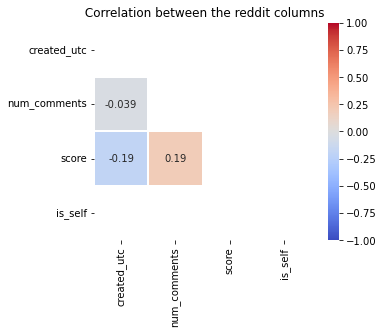

In [25]:

corr = c25k_df.corr()

plt.figure(figsize=(6,4))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(corr, cmap='coolwarm', annot=True, square=True,
            vmin = -1, vmax = 1, mask = mask,
            linecolor='white', linewidths=0.1);
plt.title(" Correlation between the reddit columns");

**Interpretation**: Not much correlation between the columns

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


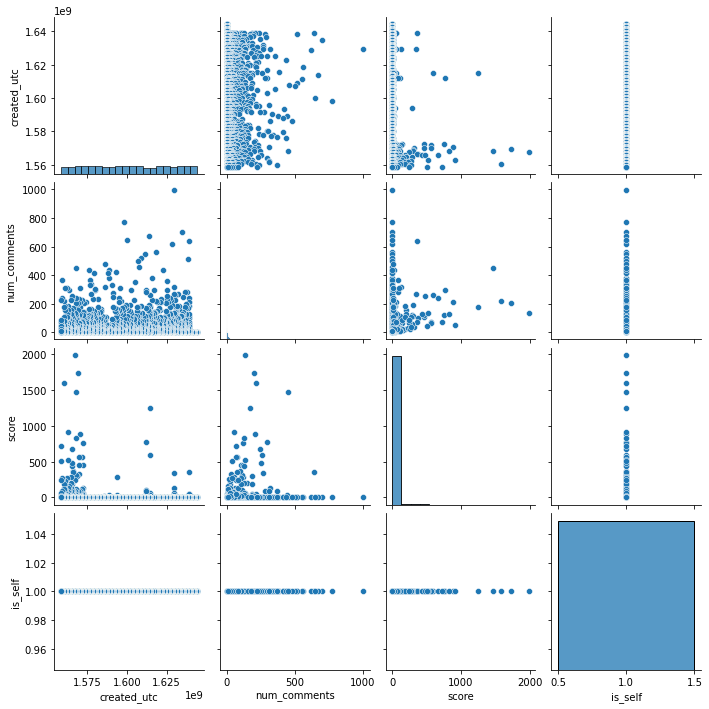

In [26]:
sns.pairplot(running_df); # see pairtplots

#### **Interpretation**: We're not doing anything with any of these columns, so the pairplots are not relevant in our scenario

Let's look a the most frequently occuring words in each subreddit


In [27]:
running_df.head(2)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,I lost my garmin charger. How can i sync data?,I have a forerunner 220 but i can't find the c...,running,1644135617,lazostat,0,1,True,2022-02-06
1,Running a marathon with no training (No Disres...,I am a 25m and am in very average shape and do...,running,1644137702,Needsomeadvice1888,0,1,True,2022-02-06


In [28]:
# Put the imports here in case we decide to move this to another notebook 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

import pickle


#### Now that we've looked at the details of each subreddit and done the initial analysis on each separately,combine both the dataframes and continue analysis on the combined dataframe

In [29]:
combined_df = running_df.append(c25k_df, ignore_index=True)


In [30]:
combined_df.info() # looks good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12281 entries, 0 to 12280
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         12281 non-null  object
 1   selftext      12281 non-null  object
 2   subreddit     12281 non-null  object
 3   created_utc   12281 non-null  int64 
 4   author        12281 non-null  object
 5   num_comments  12281 non-null  int64 
 6   score         12281 non-null  int64 
 7   is_self       12281 non-null  bool  
 8   timestamp     12281 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 779.7+ KB


#### Since the title and selftext are the only predictors, need to understand which is more relevant. Just the title, just the selftext or some combination?    

To figure this out, we need to get model performance metrics for all 3

#### Create a new column by adding the title and selftext. Add a period and newline after the title. 
Doing it in all dataframes since we need to do detailed analysis for each subreddit separately and then together

In [31]:
running_df['title_selftext'] = running_df["title"] + ".\\n" + running_df["selftext"]
c25k_df['title_selftext'] = c25k_df["title"] + ".\\n" + c25k_df["selftext"]

combined_df['title_selftext'] = combined_df["title"] + ".\\n" + combined_df["selftext"]

#combined_df['title_selftext'].head()

In [32]:
# Increase the text displayed for a column
pd.set_option('display.max_colwidth', 200)


In [33]:
combined_df['title_selftext'] 

0        I lost my garmin charger. How can i sync data?.\nI have a forerunner 220 but i can't find the charger. Is there any way to do a workout with a android app and then sync it with garmin connect to p...
1        Running a marathon with no training (No Disrespect to the sport. Please read).\nI am a 25m and am in very average shape and don't run or do any set workouts on my own. I life a semi active lifesty...
2        How can I stop myself being sick while running.\nLooking for advice from people who are in or have been in a similar situation. For context I'm a stocky 5'9 at 97kg, I do have a few bits that wobb...
3        Hard to breath when not running..\nHey , I been running for like 8 years , in the past 8 months i been doing daily 5k runs .\n\nwhen i run i feel good and its fairly easy to me , i do fast pace an...
4        I’m a novice and have signed up for a marathon - some advice needed!.\nSo I was I initially planning on signing up for the local half marathon in June, but

#### Stop words are the key to our modeling! The subreddits are quite similar (intentionally) and the models don't do a great job of classification. 
To help separate the classes (running and c25k), try to reduce the words they have in common. 

We use the CountVectorizer to convert the text data into numerical frequency data. After much hyperparameter tuning with GridSearch, use the optimal parameters here

#### Call this function in 2 passes; first pass get the list of top words, in 2nd pass use the top common words as stop words

In [34]:
# Function to Vectorize the corpus with optimal hyperparameters, using the passed stop word list (default is 'english)

def df_from_optimal_count_vectorizer( X, stop_words_l=ENGLISH_STOP_WORDS ):
    
    # Instantiate a CountVectorizer with the optimal hyperparameters.
    cvec = CountVectorizer(stop_words=stop_words_l, max_df = 0.70, min_df = 2, max_features=4000, 
                           ngram_range=(1,2))

    # Fit the vectorizer on the corpus
    cvec.fit_transform( X ) 

    return (pd.DataFrame(cvec.transform(X).todense(), columns=cvec.get_feature_names_out()))



#### Function to generate graphs. In first pass, use default english stop words

In [41]:

def visualize_top_words( stop_words = ENGLISH_STOP_WORDS):
    
    global top_running_df, top_c25k_df, top_combined_title_df, top_body_running_df, top_body_c25k_df, top_combined_body_df, ts_top_running_df, ts_top_c25k_df, ts_top_combined_title_df
    
    top_running_df = df_from_optimal_count_vectorizer(running_df["title"], stop_words)
    top_c25k_df = df_from_optimal_count_vectorizer( c25k_df['title'], stop_words)
    top_combined_title_df = df_from_optimal_count_vectorizer(combined_df["title"], stop_words)

    top_body_running_df = df_from_optimal_count_vectorizer(running_df["selftext"], stop_words)
    top_body_c25k_df = df_from_optimal_count_vectorizer( c25k_df['selftext'], stop_words)
    top_combined_body_df = df_from_optimal_count_vectorizer(combined_df["selftext"], stop_words)

    ts_top_running_df = df_from_optimal_count_vectorizer(running_df["title_selftext"], stop_words)
    ts_top_c25k_df = df_from_optimal_count_vectorizer( c25k_df['title_selftext'], stop_words)
    ts_top_combined_title_df = df_from_optimal_count_vectorizer(combined_df["title_selftext"], stop_words)


    # plot top occuring words

    plt.figure(figsize=(16,12))

    # 3 rows, 3 columns
    ax1 = plt.subplot(3, 3, 1)
    top_running_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', ax=ax1, title = 'Running Title: Top occuring words');

    ax2 = plt.subplot(3, 3, 2)
    top_c25k_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', ax=ax2, title = 'c25k Title: Top occuring words');

    ax3 = plt.subplot(3, 3, 3)
    top_combined_title_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', ax=ax3, title = 'Combined Title: Top occuring words');

    ax4 = plt.subplot(3, 3, 4)
    top_body_running_df.sum().sort_values(ascending = False).head(20).plot(color='red', kind = 'barh', 
                                            ax=ax4, title = 'Running SelfText: Top occuring words');

    ax5 = plt.subplot(3, 3, 5)
    top_body_c25k_df.sum().sort_values(ascending = False).head(20).plot(color='red', kind = 'barh', 
                                            ax=ax5, title = 'c25k SelfText: Top occuring words');

    ax6 = plt.subplot(3, 3, 6)
    top_combined_body_df.sum().sort_values(ascending = False).head(20).plot(color='red', kind = 'barh', 
                                            ax=ax6, title = 'Combined SelfText: Top occuring words');


    ax7 = plt.subplot(3, 3, 7)
    ts_top_running_df.sum().sort_values(ascending = False).head(20).plot(color = 'green', kind = 'barh', 
                                            ax=ax7, title = 'Running Title+Selftext: Top occuring words');

    ax8 = plt.subplot(3, 3, 8)
    ts_top_c25k_df.sum().sort_values(ascending = False).head(20).plot(color = 'green', kind = 'barh', 
                                            ax=ax8, title = 'c25k Title+Selftext: Top occuring words');

    ax9 = plt.subplot(3, 3, 9)
    ts_top_combined_title_df.sum().sort_values(ascending = False).head(20).plot(color = 'green', kind = 'barh', 
                                            ax=ax9, title = 'Combined Title+Selftext: Top occuring words');

    plt.tight_layout(h_pad=2, pad=2, w_pad=2)

#    plt.savefig("../images/top_words_after_stop_words.png")


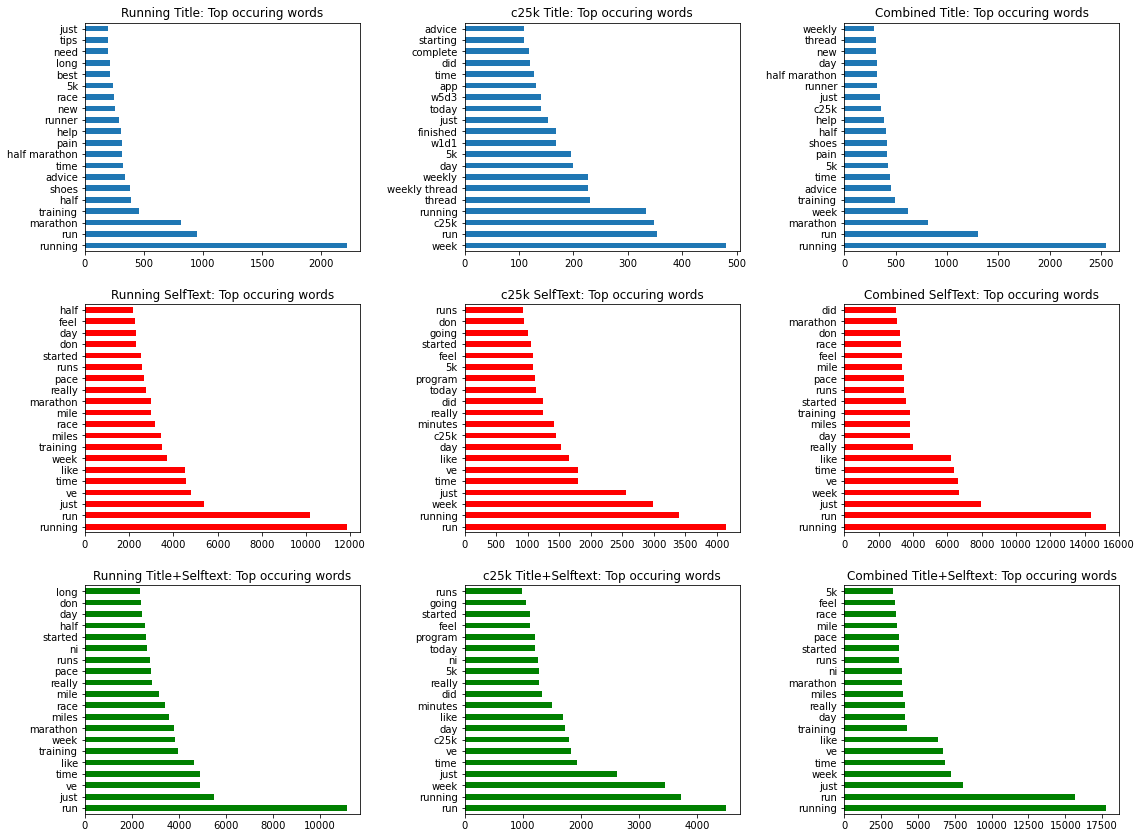

In [42]:
visualize_top_words( ENGLISH_STOP_WORDS)
#plt.suptitle("English Stop Words");

#### **Interpretation**: This shows the top words occurring in each sub-reddit with the default "english" stop words used in CountVectorizer.   
Notice that there is a lot of overlap (as expected).   
Note also there are lots of tokens like just, ve which add no meaning and could also be removed to get better model performance.  
**This indicates that we should use these top occurring words to create a new stop words list**.   
Two questions arise: 
1. Should we use the title, selftext or both to generate the list of stop words?
2. The next question is how many words should we use? 100, 1000, the full max_features of 4000? 

**Hmm, these both sound like hyperparameters...**

#### So it looks like we need to iterate over 2 sets of combinations: 
1. title, selftext and both 
2. Stop Words: english, Top 100 and Top 1000 (could choose more but will save that for the future)

In [43]:
# Find words common to both subreddits from the top 100 or 1000 commonly occurring words. 
# Should have done it in 2 nested for loops, but being lazy (and running out of time), I just manually edited the text and 
# created the stop word files for each combination: 
# stop_words_100_title
# stop_words_1000_title
# stop_words_100_body
# stop_words_1000_body
# stop_words_100_t_s
# stop_words_1000_t_s

# The code below is for one of the cases, the one which provides the best model performance: Top 100 for title_selftext

set1 = set( ts_top_running_df.sum().sort_values(ascending = False).head(100).keys() )
set2 = set( ts_top_c25k_df.sum().sort_values(ascending = False).head(100).keys() )

#print( len( set1 & set2 ))

# Use words common to both (intersection) subreddits, then do union with the 'english' stop word list of CountVectorizer'

stop_words_list = (set1 & set2).union(ENGLISH_STOP_WORDS)
print( f"Number of common words in top 1000: {len( set1 & set2 )}, Len of stop_words including ENGLISH: {len( stop_words_list)}")
#stop_words_list

# Write this stop word list to file to use later in the modeling phase. Use pickle to write/read the file
# Created separate files for each combination of title, body and title_selftext and for top 100 and 1000 words/tokens
with open(r'../data/stop_words_100_t_s_2.pkl', 'wb') as f: # keep a separate clean saved copy
    pickle.dump(stop_words_list, f)

#stop_words_list

Number of common words in top 1000: 75, Len of stop_words including ENGLISH: 393


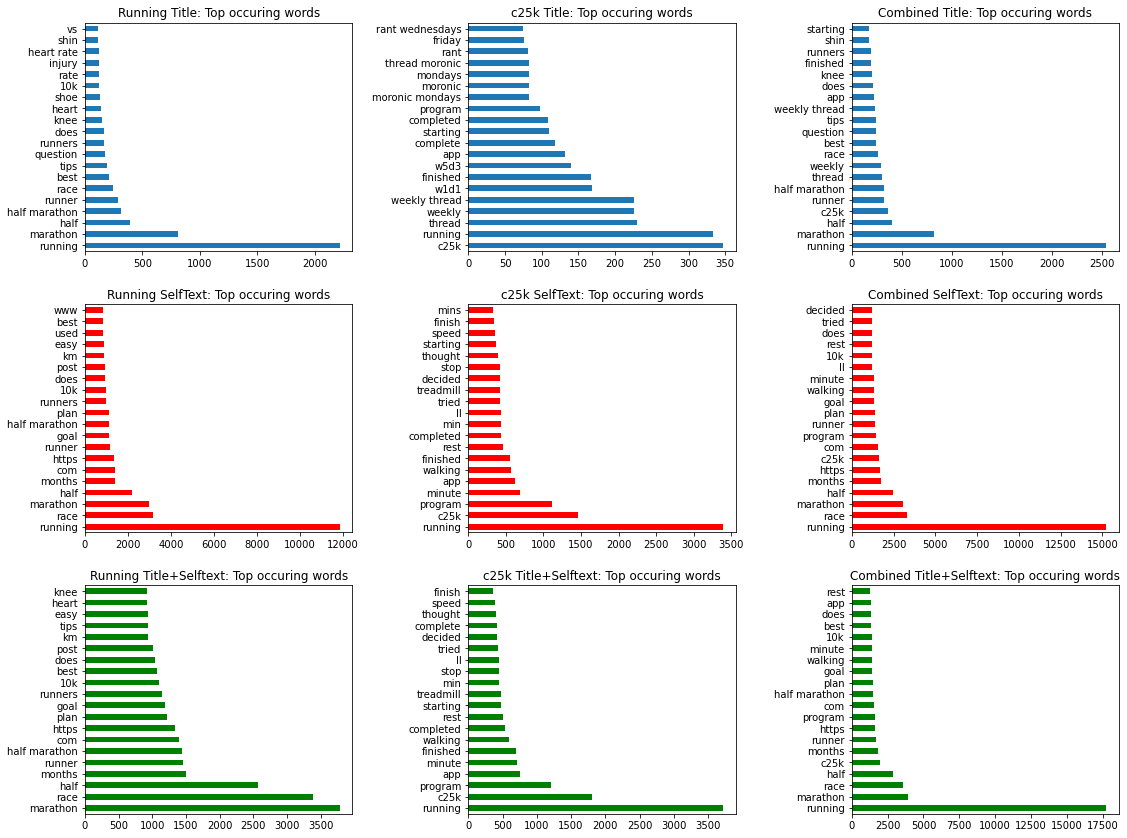

In [44]:
# Now print graphs without these top words
visualize_top_words( stop_words_list)

#### **Interpretation**: <font color="green"> Much much better!! Can notice a clear separation of the two subreddits now. </font>
Based on iterations of these 9 combinations and comparing the performance of the models,  the Title+Selftext list of stop words gives the best (bottom right, in the charts above)

Note: running still shows up, couldn't figure out why, maybe this is what gives the warning during fit(): Warning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['running'] not in stop_words.

## Done with EDA!! Next notebook contains the preprocessing and modeling

### Additional stuff after submission of Project


#### Collect some stats on the subs
# how many posts/submissions, how many per day, start and end  date 
running: 9914 posts
100 per 10 days; 100 times: go back 1000 days : 2.75 years 2 years 9 months: 
Oldest: 5/22/2019
Newest: 5/22/2019

89 on 2/6/2022
7 on 2/7: then reached cap of 100
went back 10 days


C25k: 4036! Hmm suddenly changed!!  4336
Oldest: 5/23/2019
Newest: 2/15/2022




In [71]:
running_df.info()   
#running_df['timestamp'].sort_index()[80:140]

#c25k_df['timestamp'].sort_values()[5:50]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8245 entries, 0 to 9914
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           8245 non-null   object
 1   selftext        8245 non-null   object
 2   subreddit       8245 non-null   object
 3   created_utc     8245 non-null   int64 
 4   author          8245 non-null   object
 5   num_comments    8245 non-null   int64 
 6   score           8245 non-null   int64 
 7   is_self         8245 non-null   bool  
 8   timestamp       8245 non-null   object
 9   title_selftext  8245 non-null   object
dtypes: bool(1), int64(3), object(6)
memory usage: 910.2+ KB


In [74]:
running_df.groupby("timestamp").mean()

,created_utc,num_comments,score,is_self
timestamp,,,,
2019-05-22,1.558592e+09,10.500000,0.000000,True
2019-05-23,1.558640e+09,12.520833,16.979167,True
2019-05-24,1.558716e+09,15.724138,31.517241,True
2019-06-01,1.559455e+09,7.000000,0.000000,True
2019-06-02,1.559506e+09,12.511628,9.744186,True
...,...,...,...,...
2022-01-17,1.642450e+09,0.000000,1.000000,True
2022-01-26,1.643265e+09,0.000000,1.000000,True
2022-01-27,1.643320e+09,0.000000,1.000000,True


In [75]:
c25k_df.groupby("timestamp").mean()

,created_utc,num_comments,score,is_self
timestamp,,,,
2019-05-23,1.558623e+09,8.461538,10.461538,True
2019-05-24,1.558738e+09,5.000000,14.142857,True
2019-05-25,1.558800e+09,3.600000,24.600000,True
2019-05-26,1.558907e+09,7.625000,13.375000,True
2019-05-27,1.558984e+09,5.384615,9.923077,True
...,...,...,...,...
2022-02-11,1.644615e+09,0.000000,1.000000,True
2022-02-12,1.644686e+09,0.000000,1.000000,True
2022-02-13,1.644784e+09,0.000000,1.000000,True


In [76]:
c25k_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4036 entries, 0 to 4336
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           4036 non-null   object
 1   selftext        4036 non-null   object
 2   subreddit       4036 non-null   object
 3   created_utc     4036 non-null   int64 
 4   author          4036 non-null   object
 5   num_comments    4036 non-null   int64 
 6   score           4036 non-null   int64 
 7   is_self         4036 non-null   bool  
 8   timestamp       4036 non-null   object
 9   title_selftext  4036 non-null   object
dtypes: bool(1), int64(3), object(6)
memory usage: 319.3+ KB
